<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [417]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os

In [418]:
file_paths = glob.glob('MVTec AD Dataset//bottle//*//*//*.png')
file_paths = sorted([
    path for path in file_paths
    if os.path.basename(path) in [f'{i:03}.png' for i in range(19)]
])

In [419]:
img = cv2.imread(file_paths[0])

In [420]:
img.shape

(900, 900, 3)

In [421]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    img = cv2.resize(img, (900, 900))
    all_data.append(img)
all_data = np.stack(all_data)
print(all_data.shape)

100%|██████████| 95/95 [00:01<00:00, 65.29it/s]


(95, 900, 900, 3)


In [422]:
file_paths

['MVTec AD Dataset//bottle\\test\\broken_large\\000.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\001.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\002.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\003.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\004.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\005.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\006.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\007.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\008.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\009.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\010.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\011.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\012.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\013.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\014.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\015.png',
 'MVTec AD Dataset//bottle\\test\\broken_large\\016.png',
 'MVTec AD Dat

Classes: ['broken_large', 'broken_small', 'contamination', 'good']


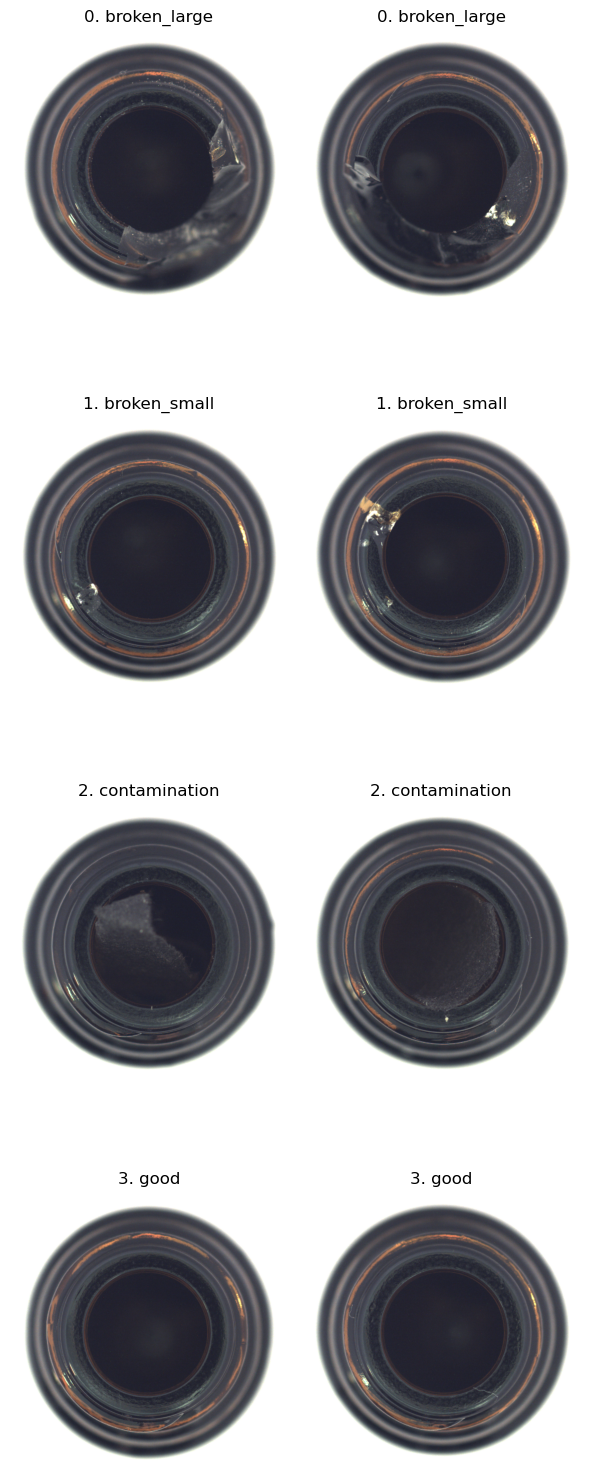

In [423]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

classes = sorted(set([path.split('\\')[2] for path in file_paths]))
print(f'Classes: {classes}')


images_per_classes = defaultdict(int)
for path in file_paths:
    cls = path.split("\\")[2]
    images_per_classes[cls] += 1

fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))
index = 0
for i, class_name in enumerate(classes):
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')
    index += images_per_classes[class_name]

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [424]:
for i in images_per_classes.keys():
    print(i, end=', ')

broken_large, broken_small, contamination, good, 

In [425]:
images_per_classes

defaultdict(int,
            {'broken_large': 19,
             'broken_small': 19,
             'contamination': 19,
             'good': 38})

In [426]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 4

x_train = []
x_val = []
y_train = []
y_val = []

start_index = 0
for i in range(num_classes):
    images_per_class = images_per_classes[classes[i]]
    train_images_per_class = int(images_per_class * 0.8)
    val_images_per_class = images_per_class - train_images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])
    y_train.extend([i] * train_images_per_class)
    y_val.extend([i] * val_images_per_class)
    start_index += images_per_class

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val = np.array(y_val)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (75, 3, 900, 900)
Shape of x_val: (20, 3, 900, 900)
Shape of y_train: (75,)
Shape of y_val: (20,)


In [427]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

size = 512
train_transforms = transforms.Compose(
    [
        transforms.Resize((size, size)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [428]:
batch_size = 64

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

## B. Defining Neural Networks

In [429]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 4

# change # of class from 1000 into 8 in the last layer
# model.fc = nn.Linear(num_ftrs, num_class)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  # 第 1 層
    nn.ReLU(),
    # nn.Dropout(0.3),

    nn.Linear(1024, 512),       # 第 2 層
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(512, 256),       # 第 3 層
    nn.ReLU(),
    nn.Dropout(0.1),

    nn.Linear(256, num_class)  # 輸出層
)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [430]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 150
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  1%|          | 1/150 [00:01<02:48,  1.13s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 1/150, Train loss: 1.2852, Train acc: 29.3333%, Val loss: 1.3538, Val acc: 40.0000%, Best Val loss: 1.3538 Best Val acc: 40.00%


  1%|▏         | 2/150 [00:02<02:36,  1.06s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 2/150, Train loss: 1.4681, Train acc: 40.0000%, Val loss: 1.3378, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  2%|▏         | 3/150 [00:03<02:32,  1.04s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 3/150, Train loss: 1.3511, Train acc: 40.0000%, Val loss: 1.3584, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  3%|▎         | 4/150 [00:04<02:29,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 4/150, Train loss: 1.3414, Train acc: 41.3333%, Val loss: 1.3613, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  3%|▎         | 5/150 [00:05<02:27,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 5/150, Train loss: 1.3154, Train acc: 41.3333%, Val loss: 1.3478, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  4%|▍         | 6/150 [00:06<02:26,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 6/150, Train loss: 1.2802, Train acc: 40.0000%, Val loss: 1.3493, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  5%|▍         | 7/150 [00:07<02:26,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 7/150, Train loss: 1.1864, Train acc: 40.0000%, Val loss: 1.3828, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  5%|▌         | 8/150 [00:08<02:24,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 8/150, Train loss: 1.4070, Train acc: 40.0000%, Val loss: 1.3629, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  6%|▌         | 9/150 [00:09<02:23,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 9/150, Train loss: 1.1688, Train acc: 42.6667%, Val loss: 1.3553, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  7%|▋         | 10/150 [00:10<02:22,  1.02s/it]

Confusion Matrix:
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 10/150, Train loss: 1.2645, Train acc: 44.0000%, Val loss: 1.3396, Val acc: 40.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  7%|▋         | 11/150 [00:11<02:19,  1.00s/it]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 11/150, Train loss: 1.1910, Train acc: 44.0000%, Val loss: 1.3767, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  8%|▊         | 12/150 [00:12<02:16,  1.01it/s]

Confusion Matrix:
[[0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]
 [0 0 8 0]]
Epoch 12/150, Train loss: 1.1551, Train acc: 52.0000%, Val loss: 1.3795, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  9%|▊         | 13/150 [00:13<02:14,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 13/150, Train loss: 1.2024, Train acc: 45.3333%, Val loss: 1.4365, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


  9%|▉         | 14/150 [00:14<02:13,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 14/150, Train loss: 1.1029, Train acc: 53.3333%, Val loss: 1.7404, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 10%|█         | 15/150 [00:15<02:11,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 15/150, Train loss: 1.0130, Train acc: 57.3333%, Val loss: 1.6736, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 11%|█         | 16/150 [00:16<02:10,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 16/150, Train loss: 1.3489, Train acc: 52.0000%, Val loss: 2.3783, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 11%|█▏        | 17/150 [00:17<02:09,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 17/150, Train loss: 1.2701, Train acc: 52.0000%, Val loss: 2.3590, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 12%|█▏        | 18/150 [00:18<02:09,  1.02it/s]

Confusion Matrix:
[[0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]
 [0 0 8 0]]
Epoch 18/150, Train loss: 0.9365, Train acc: 54.6667%, Val loss: 1.3927, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 13%|█▎        | 19/150 [00:18<02:07,  1.02it/s]

Confusion Matrix:
[[0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]
 [0 0 8 0]]
Epoch 19/150, Train loss: 1.1151, Train acc: 48.0000%, Val loss: 1.3992, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 13%|█▎        | 20/150 [00:19<02:06,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 20/150, Train loss: 1.2909, Train acc: 44.0000%, Val loss: 1.9446, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 14%|█▍        | 21/150 [00:20<02:07,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 21/150, Train loss: 1.1520, Train acc: 54.6667%, Val loss: 2.3784, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 15%|█▍        | 22/150 [00:21<02:06,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 22/150, Train loss: 1.1491, Train acc: 40.0000%, Val loss: 2.1737, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 15%|█▌        | 23/150 [00:22<02:05,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 23/150, Train loss: 1.0311, Train acc: 65.3333%, Val loss: 1.8428, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 16%|█▌        | 24/150 [00:23<02:03,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 24/150, Train loss: 0.9460, Train acc: 57.3333%, Val loss: 1.5832, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 17%|█▋        | 25/150 [00:24<02:02,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 25/150, Train loss: 0.9974, Train acc: 49.3333%, Val loss: 1.7207, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 17%|█▋        | 26/150 [00:25<02:01,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 26/150, Train loss: 1.1935, Train acc: 52.0000%, Val loss: 2.6436, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 18%|█▊        | 27/150 [00:26<02:00,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 27/150, Train loss: 0.9972, Train acc: 57.3333%, Val loss: 3.3303, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 19%|█▊        | 28/150 [00:27<01:59,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 28/150, Train loss: 0.9614, Train acc: 54.6667%, Val loss: 3.0996, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 19%|█▉        | 29/150 [00:28<01:58,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 29/150, Train loss: 0.9783, Train acc: 56.0000%, Val loss: 3.2274, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 20%|██        | 30/150 [00:29<01:57,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 30/150, Train loss: 0.9621, Train acc: 57.3333%, Val loss: 3.9739, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 21%|██        | 31/150 [00:30<01:56,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 31/150, Train loss: 0.9604, Train acc: 58.6667%, Val loss: 3.9194, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 21%|██▏       | 32/150 [00:31<01:54,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 32/150, Train loss: 0.8634, Train acc: 54.6667%, Val loss: 3.0347, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 22%|██▏       | 33/150 [00:32<01:54,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [6 2 0 0]]
Epoch 33/150, Train loss: 0.8854, Train acc: 66.6667%, Val loss: 2.4707, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 23%|██▎       | 34/150 [00:33<01:54,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 34/150, Train loss: 1.0868, Train acc: 54.6667%, Val loss: 3.5387, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 23%|██▎       | 35/150 [00:34<01:53,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]]
Epoch 35/150, Train loss: 0.8951, Train acc: 64.0000%, Val loss: 4.1375, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 24%|██▍       | 36/150 [00:35<01:52,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [3 1 0 0]
 [1 7 0 0]]
Epoch 36/150, Train loss: 0.8784, Train acc: 57.3333%, Val loss: 2.1091, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 25%|██▍       | 37/150 [00:36<01:51,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 2 0 0]
 [1 3 0 0]
 [0 4 4 0]]
Epoch 37/150, Train loss: 0.8941, Train acc: 58.6667%, Val loss: 1.3801, Val acc: 30.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 25%|██▌       | 38/150 [00:37<01:50,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [4 0 0 0]
 [3 1 0 0]
 [1 5 2 0]]
Epoch 38/150, Train loss: 0.8633, Train acc: 62.6667%, Val loss: 1.9592, Val acc: 20.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 26%|██▌       | 39/150 [00:38<01:49,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [2 2 0 0]
 [0 5 3 0]]
Epoch 39/150, Train loss: 0.9353, Train acc: 60.0000%, Val loss: 1.6577, Val acc: 25.0000%, Best Val loss: 1.3378 Best Val acc: 40.00%


 27%|██▋       | 40/150 [00:39<01:50,  1.00s/it]

Confusion Matrix:
[[4 0 0 0]
 [2 2 0 0]
 [0 4 0 0]
 [0 1 1 6]]
Epoch 40/150, Train loss: 0.7841, Train acc: 69.3333%, Val loss: 0.8846, Val acc: 60.0000%, Best Val loss: 0.8846 Best Val acc: 60.00%


 27%|██▋       | 41/150 [00:40<01:48,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [2 2 0 0]
 [0 3 0 5]]
Epoch 41/150, Train loss: 0.7758, Train acc: 64.0000%, Val loss: 1.2657, Val acc: 50.0000%, Best Val loss: 0.8846 Best Val acc: 60.00%


 28%|██▊       | 42/150 [00:41<01:46,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [1 3 0 0]
 [0 3 0 5]]
Epoch 42/150, Train loss: 0.7419, Train acc: 65.3333%, Val loss: 1.0977, Val acc: 50.0000%, Best Val loss: 0.8846 Best Val acc: 60.00%


 29%|██▊       | 43/150 [00:42<01:47,  1.00s/it]

Confusion Matrix:
[[4 0 0 0]
 [1 3 0 0]
 [0 4 0 0]
 [0 1 0 7]]
Epoch 43/150, Train loss: 0.8780, Train acc: 68.0000%, Val loss: 0.9439, Val acc: 70.0000%, Best Val loss: 0.8846 Best Val acc: 70.00%


 29%|██▉       | 44/150 [00:43<01:46,  1.00s/it]

Confusion Matrix:
[[4 0 0 0]
 [0 4 0 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 44/150, Train loss: 0.9170, Train acc: 66.6667%, Val loss: 0.6745, Val acc: 80.0000%, Best Val loss: 0.6745 Best Val acc: 80.00%


 30%|███       | 45/150 [00:44<01:43,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 0 1]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 45/150, Train loss: 0.7842, Train acc: 68.0000%, Val loss: 0.5076, Val acc: 75.0000%, Best Val loss: 0.5076 Best Val acc: 80.00%


 31%|███       | 46/150 [00:45<01:41,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 46/150, Train loss: 0.8453, Train acc: 61.3333%, Val loss: 0.4718, Val acc: 75.0000%, Best Val loss: 0.4718 Best Val acc: 80.00%


 31%|███▏      | 47/150 [00:46<01:42,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 47/150, Train loss: 0.7495, Train acc: 76.0000%, Val loss: 0.4755, Val acc: 85.0000%, Best Val loss: 0.4718 Best Val acc: 85.00%


 32%|███▏      | 48/150 [00:47<01:41,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 48/150, Train loss: 0.7580, Train acc: 73.3333%, Val loss: 0.4739, Val acc: 75.0000%, Best Val loss: 0.4718 Best Val acc: 85.00%


 33%|███▎      | 49/150 [00:48<01:40,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 49/150, Train loss: 0.6251, Train acc: 73.3333%, Val loss: 0.4631, Val acc: 75.0000%, Best Val loss: 0.4631 Best Val acc: 85.00%


 33%|███▎      | 50/150 [00:49<01:38,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 0 1]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 50/150, Train loss: 0.7281, Train acc: 70.6667%, Val loss: 0.5027, Val acc: 75.0000%, Best Val loss: 0.4631 Best Val acc: 85.00%


 34%|███▍      | 51/150 [00:50<01:37,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 0 1 3]
 [0 0 0 8]]
Epoch 51/150, Train loss: 0.6428, Train acc: 72.0000%, Val loss: 0.6190, Val acc: 75.0000%, Best Val loss: 0.4631 Best Val acc: 85.00%


 35%|███▍      | 52/150 [00:51<01:36,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 52/150, Train loss: 0.5359, Train acc: 70.6667%, Val loss: 0.5679, Val acc: 80.0000%, Best Val loss: 0.4631 Best Val acc: 85.00%


 35%|███▌      | 53/150 [00:52<01:35,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 1 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 53/150, Train loss: 0.7156, Train acc: 70.6667%, Val loss: 0.4599, Val acc: 70.0000%, Best Val loss: 0.4599 Best Val acc: 85.00%


 36%|███▌      | 54/150 [00:53<01:33,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 1 0]
 [0 3 0 1]
 [0 0 0 8]]
Epoch 54/150, Train loss: 0.6241, Train acc: 72.0000%, Val loss: 0.4435, Val acc: 70.0000%, Best Val loss: 0.4435 Best Val acc: 85.00%


 37%|███▋      | 55/150 [00:54<01:33,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 1 2]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 55/150, Train loss: 0.6099, Train acc: 68.0000%, Val loss: 0.9410, Val acc: 60.0000%, Best Val loss: 0.4435 Best Val acc: 85.00%


 37%|███▋      | 56/150 [00:55<01:33,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 1 2]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 56/150, Train loss: 0.9122, Train acc: 69.3333%, Val loss: 1.0015, Val acc: 60.0000%, Best Val loss: 0.4435 Best Val acc: 85.00%


 38%|███▊      | 57/150 [00:56<01:32,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 57/150, Train loss: 0.6800, Train acc: 68.0000%, Val loss: 0.4109, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 39%|███▊      | 58/150 [00:57<01:30,  1.01it/s]

Confusion Matrix:
[[4 0 0 0]
 [0 3 1 0]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 58/150, Train loss: 1.2114, Train acc: 68.0000%, Val loss: 0.4432, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 39%|███▉      | 59/150 [00:58<01:29,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 0 3]
 [0 0 0 4]
 [0 0 0 8]]
Epoch 59/150, Train loss: 0.6372, Train acc: 72.0000%, Val loss: 1.1337, Val acc: 60.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 40%|████      | 60/150 [00:59<01:29,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 0 3]
 [0 0 1 3]
 [0 0 0 8]]
Epoch 60/150, Train loss: 1.0114, Train acc: 58.6667%, Val loss: 0.9035, Val acc: 65.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 41%|████      | 61/150 [01:00<01:27,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 61/150, Train loss: 0.7194, Train acc: 66.6667%, Val loss: 0.5508, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 41%|████▏     | 62/150 [01:01<01:26,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [1 0 2 1]
 [0 0 0 8]]
Epoch 62/150, Train loss: 0.9934, Train acc: 76.0000%, Val loss: 0.5900, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 42%|████▏     | 63/150 [01:02<01:25,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 63/150, Train loss: 0.7991, Train acc: 74.6667%, Val loss: 0.6345, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 43%|████▎     | 64/150 [01:03<01:24,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 0 3]
 [0 0 1 3]
 [0 0 0 8]]
Epoch 64/150, Train loss: 0.7871, Train acc: 65.3333%, Val loss: 0.7372, Val acc: 65.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 43%|████▎     | 65/150 [01:04<01:22,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 65/150, Train loss: 0.7902, Train acc: 57.3333%, Val loss: 0.6443, Val acc: 65.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 44%|████▍     | 66/150 [01:05<01:21,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 66/150, Train loss: 0.7948, Train acc: 69.3333%, Val loss: 0.6092, Val acc: 65.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 45%|████▍     | 67/150 [01:06<01:20,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 67/150, Train loss: 0.6695, Train acc: 72.0000%, Val loss: 0.5983, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 45%|████▌     | 68/150 [01:07<01:18,  1.04it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 2 1 1]
 [0 0 0 8]]
Epoch 68/150, Train loss: 0.7155, Train acc: 70.6667%, Val loss: 0.5925, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 46%|████▌     | 69/150 [01:08<01:18,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 69/150, Train loss: 0.6269, Train acc: 73.3333%, Val loss: 0.5853, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 47%|████▋     | 70/150 [01:09<01:17,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 0 3]
 [0 0 0 8]]
Epoch 70/150, Train loss: 0.5635, Train acc: 72.0000%, Val loss: 0.6369, Val acc: 65.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 47%|████▋     | 71/150 [01:10<01:17,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 71/150, Train loss: 1.0335, Train acc: 58.6667%, Val loss: 0.5575, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 48%|████▊     | 72/150 [01:11<01:15,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [1 2 1 0]
 [0 0 0 8]]
Epoch 72/150, Train loss: 0.5076, Train acc: 84.0000%, Val loss: 0.8291, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 49%|████▊     | 73/150 [01:12<01:15,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [1 1 2 0]
 [0 0 0 8]]
Epoch 73/150, Train loss: 0.8144, Train acc: 52.0000%, Val loss: 0.5899, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 49%|████▉     | 74/150 [01:13<01:14,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 74/150, Train loss: 0.8801, Train acc: 73.3333%, Val loss: 0.5352, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 50%|█████     | 75/150 [01:14<01:13,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 75/150, Train loss: 0.5415, Train acc: 74.6667%, Val loss: 0.5508, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 51%|█████     | 76/150 [01:15<01:12,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 1 0]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 76/150, Train loss: 0.5087, Train acc: 80.0000%, Val loss: 0.4865, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 85.00%


 51%|█████▏    | 77/150 [01:16<01:13,  1.00s/it]

Confusion Matrix:
[[4 0 0 0]
 [1 3 0 0]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 77/150, Train loss: 0.8834, Train acc: 74.6667%, Val loss: 0.4685, Val acc: 90.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 52%|█████▏    | 78/150 [01:17<01:11,  1.00it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 78/150, Train loss: 0.8762, Train acc: 78.6667%, Val loss: 0.4527, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 53%|█████▎    | 79/150 [01:18<01:10,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 3 0 0]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 79/150, Train loss: 0.5516, Train acc: 77.3333%, Val loss: 0.4657, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 53%|█████▎    | 80/150 [01:19<01:09,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 80/150, Train loss: 0.7817, Train acc: 81.3333%, Val loss: 0.4354, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 54%|█████▍    | 81/150 [01:20<01:07,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 81/150, Train loss: 0.5023, Train acc: 76.0000%, Val loss: 0.6306, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 55%|█████▍    | 82/150 [01:20<01:06,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 1 1 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 82/150, Train loss: 1.2524, Train acc: 58.6667%, Val loss: 0.5746, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 55%|█████▌    | 83/150 [01:21<01:05,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 0 1 0]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 83/150, Train loss: 0.7426, Train acc: 74.6667%, Val loss: 0.5559, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 56%|█████▌    | 84/150 [01:22<01:04,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 1 0 1]
 [1 1 1 1]
 [0 0 0 8]]
Epoch 84/150, Train loss: 1.0208, Train acc: 74.6667%, Val loss: 0.5781, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 57%|█████▋    | 85/150 [01:23<01:03,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 85/150, Train loss: 0.7315, Train acc: 73.3333%, Val loss: 0.6389, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 57%|█████▋    | 86/150 [01:24<01:02,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 86/150, Train loss: 0.8734, Train acc: 65.3333%, Val loss: 0.5775, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 58%|█████▊    | 87/150 [01:25<01:01,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 87/150, Train loss: 0.7501, Train acc: 76.0000%, Val loss: 0.5668, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 59%|█████▊    | 88/150 [01:26<01:00,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 2 0 0]
 [1 1 2 0]
 [0 0 0 8]]
Epoch 88/150, Train loss: 0.5850, Train acc: 76.0000%, Val loss: 0.6726, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 59%|█████▉    | 89/150 [01:27<00:59,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 3 0 0]
 [0 2 1 1]
 [0 0 0 8]]
Epoch 89/150, Train loss: 0.5973, Train acc: 69.3333%, Val loss: 0.6521, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 60%|██████    | 90/150 [01:28<00:58,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 90/150, Train loss: 0.7050, Train acc: 76.0000%, Val loss: 0.5530, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 61%|██████    | 91/150 [01:29<00:57,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 91/150, Train loss: 0.5627, Train acc: 78.6667%, Val loss: 0.5627, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 61%|██████▏   | 92/150 [01:30<00:56,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 92/150, Train loss: 0.8961, Train acc: 69.3333%, Val loss: 0.5072, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 62%|██████▏   | 93/150 [01:31<00:55,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 3 0 0]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 93/150, Train loss: 1.1118, Train acc: 77.3333%, Val loss: 0.5241, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 63%|██████▎   | 94/150 [01:32<00:54,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [1 2 1 0]
 [0 0 0 8]]
Epoch 94/150, Train loss: 0.5991, Train acc: 77.3333%, Val loss: 0.8728, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 63%|██████▎   | 95/150 [01:33<00:53,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 3 0 0]
 [1 1 2 0]
 [0 0 0 8]]
Epoch 95/150, Train loss: 1.1885, Train acc: 56.0000%, Val loss: 0.5572, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 64%|██████▍   | 96/150 [01:34<00:52,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 96/150, Train loss: 0.5913, Train acc: 81.3333%, Val loss: 0.5025, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 65%|██████▍   | 97/150 [01:35<00:51,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 1 2]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 97/150, Train loss: 0.7496, Train acc: 70.6667%, Val loss: 0.7034, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 65%|██████▌   | 98/150 [01:36<00:51,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 1 2 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 98/150, Train loss: 0.8092, Train acc: 62.6667%, Val loss: 0.6678, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 66%|██████▌   | 99/150 [01:37<00:50,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 1 1 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 99/150, Train loss: 1.2751, Train acc: 64.0000%, Val loss: 0.5171, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 67%|██████▋   | 100/150 [01:38<00:49,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 2 0 0]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 100/150, Train loss: 0.7507, Train acc: 69.3333%, Val loss: 0.5248, Val acc: 85.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 67%|██████▋   | 101/150 [01:39<00:48,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 1 0 0]
 [1 1 2 0]
 [0 0 0 8]]
Epoch 101/150, Train loss: 0.6574, Train acc: 74.6667%, Val loss: 0.8124, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 68%|██████▊   | 102/150 [01:40<00:47,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 2 0 0]
 [1 2 1 0]
 [0 0 0 8]]
Epoch 102/150, Train loss: 1.0726, Train acc: 42.6667%, Val loss: 0.7042, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 69%|██████▊   | 103/150 [01:41<00:46,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 103/150, Train loss: 0.8264, Train acc: 61.3333%, Val loss: 0.5480, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 69%|██████▉   | 104/150 [01:42<00:45,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 104/150, Train loss: 0.7694, Train acc: 77.3333%, Val loss: 0.5270, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 70%|███████   | 105/150 [01:43<00:43,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 105/150, Train loss: 0.6616, Train acc: 80.0000%, Val loss: 0.5443, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 71%|███████   | 106/150 [01:44<00:42,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 2 2]
 [0 0 0 8]]
Epoch 106/150, Train loss: 0.7471, Train acc: 72.0000%, Val loss: 0.5417, Val acc: 75.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 71%|███████▏  | 107/150 [01:45<00:41,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 107/150, Train loss: 0.5758, Train acc: 82.6667%, Val loss: 0.5266, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 72%|███████▏  | 108/150 [01:46<00:41,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 108/150, Train loss: 0.5660, Train acc: 76.0000%, Val loss: 0.5064, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 73%|███████▎  | 109/150 [01:47<00:40,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 2 1]
 [0 0 0 8]]
Epoch 109/150, Train loss: 0.7515, Train acc: 77.3333%, Val loss: 0.4642, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 73%|███████▎  | 110/150 [01:48<00:39,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 110/150, Train loss: 0.7195, Train acc: 76.0000%, Val loss: 0.4338, Val acc: 90.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 74%|███████▍  | 111/150 [01:49<00:37,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 111/150, Train loss: 0.5604, Train acc: 77.3333%, Val loss: 0.4765, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 75%|███████▍  | 112/150 [01:50<00:36,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 112/150, Train loss: 0.7470, Train acc: 82.6667%, Val loss: 0.5155, Val acc: 70.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 75%|███████▌  | 113/150 [01:51<00:36,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 113/150, Train loss: 0.4612, Train acc: 82.6667%, Val loss: 0.4123, Val acc: 80.0000%, Best Val loss: 0.4109 Best Val acc: 90.00%


 76%|███████▌  | 114/150 [01:52<00:34,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 114/150, Train loss: 0.6136, Train acc: 84.0000%, Val loss: 0.3849, Val acc: 80.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 77%|███████▋  | 115/150 [01:53<00:34,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 3 0 0]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 115/150, Train loss: 0.6185, Train acc: 77.3333%, Val loss: 0.4326, Val acc: 80.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 77%|███████▋  | 116/150 [01:54<00:33,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 3 0 0]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 116/150, Train loss: 0.5119, Train acc: 78.6667%, Val loss: 0.4237, Val acc: 80.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 78%|███████▊  | 117/150 [01:55<00:32,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 3 0 0]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 117/150, Train loss: 0.7219, Train acc: 74.6667%, Val loss: 0.4274, Val acc: 80.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 79%|███████▊  | 118/150 [01:56<00:31,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 118/150, Train loss: 0.5731, Train acc: 78.6667%, Val loss: 0.4356, Val acc: 75.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 79%|███████▉  | 119/150 [01:57<00:30,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 2 1 1]
 [0 0 0 8]]
Epoch 119/150, Train loss: 0.3688, Train acc: 88.0000%, Val loss: 0.4716, Val acc: 70.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 80%|████████  | 120/150 [01:58<00:29,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 120/150, Train loss: 0.4713, Train acc: 78.6667%, Val loss: 0.4803, Val acc: 75.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 81%|████████  | 121/150 [01:59<00:28,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 121/150, Train loss: 0.2929, Train acc: 86.6667%, Val loss: 0.4030, Val acc: 80.0000%, Best Val loss: 0.3849 Best Val acc: 90.00%


 81%|████████▏ | 122/150 [02:00<00:27,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 122/150, Train loss: 0.3561, Train acc: 84.0000%, Val loss: 0.3539, Val acc: 80.0000%, Best Val loss: 0.3539 Best Val acc: 90.00%


 82%|████████▏ | 123/150 [02:01<00:26,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 123/150, Train loss: 0.5074, Train acc: 88.0000%, Val loss: 0.3314, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 83%|████████▎ | 124/150 [02:02<00:25,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 124/150, Train loss: 0.6976, Train acc: 84.0000%, Val loss: 0.3851, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 83%|████████▎ | 125/150 [02:03<00:24,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 125/150, Train loss: 0.5547, Train acc: 84.0000%, Val loss: 0.4516, Val acc: 70.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 84%|████████▍ | 126/150 [02:03<00:23,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 126/150, Train loss: 0.5224, Train acc: 82.6667%, Val loss: 0.3813, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 85%|████████▍ | 127/150 [02:04<00:22,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 127/150, Train loss: 0.6939, Train acc: 74.6667%, Val loss: 0.4198, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 85%|████████▌ | 128/150 [02:05<00:21,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 128/150, Train loss: 0.6611, Train acc: 78.6667%, Val loss: 0.5400, Val acc: 70.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 86%|████████▌ | 129/150 [02:06<00:20,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 2 1 1]
 [0 0 0 8]]
Epoch 129/150, Train loss: 0.5118, Train acc: 74.6667%, Val loss: 0.4786, Val acc: 70.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 87%|████████▋ | 130/150 [02:07<00:19,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 2 1 1]
 [0 0 0 8]]
Epoch 130/150, Train loss: 0.6769, Train acc: 69.3333%, Val loss: 0.4694, Val acc: 75.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 87%|████████▋ | 131/150 [02:08<00:18,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 131/150, Train loss: 0.5424, Train acc: 76.0000%, Val loss: 0.3538, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 88%|████████▊ | 132/150 [02:09<00:17,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 1 1 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 132/150, Train loss: 1.0631, Train acc: 80.0000%, Val loss: 0.3904, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 89%|████████▊ | 133/150 [02:10<00:16,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 133/150, Train loss: 0.6521, Train acc: 74.6667%, Val loss: 0.3497, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 89%|████████▉ | 134/150 [02:11<00:15,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 134/150, Train loss: 0.5576, Train acc: 81.3333%, Val loss: 0.5262, Val acc: 70.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 90%|█████████ | 135/150 [02:12<00:14,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 1 2]
 [0 0 0 8]]
Epoch 135/150, Train loss: 0.4871, Train acc: 78.6667%, Val loss: 0.5697, Val acc: 70.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 91%|█████████ | 136/150 [02:13<00:13,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 1 0 1]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 136/150, Train loss: 0.4366, Train acc: 80.0000%, Val loss: 0.5622, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 91%|█████████▏| 137/150 [02:14<00:12,  1.02it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 0 0 1]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 137/150, Train loss: 0.6132, Train acc: 82.6667%, Val loss: 0.5396, Val acc: 75.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 92%|█████████▏| 138/150 [02:15<00:11,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [3 0 0 1]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 138/150, Train loss: 0.4600, Train acc: 81.3333%, Val loss: 0.4937, Val acc: 75.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 93%|█████████▎| 139/150 [02:16<00:10,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [2 1 0 1]
 [1 0 3 0]
 [0 0 0 8]]
Epoch 139/150, Train loss: 0.5138, Train acc: 80.0000%, Val loss: 0.4520, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 93%|█████████▎| 140/150 [02:17<00:09,  1.03it/s]

Confusion Matrix:
[[4 0 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 140/150, Train loss: 0.5103, Train acc: 82.6667%, Val loss: 0.4521, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 94%|█████████▍| 141/150 [02:18<00:08,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 2 2 0]
 [0 0 0 8]]
Epoch 141/150, Train loss: 0.5633, Train acc: 81.3333%, Val loss: 0.4398, Val acc: 75.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 95%|█████████▍| 142/150 [02:19<00:07,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 142/150, Train loss: 0.4155, Train acc: 89.3333%, Val loss: 0.3765, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 95%|█████████▌| 143/150 [02:20<00:06,  1.01it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 143/150, Train loss: 0.2862, Train acc: 88.0000%, Val loss: 0.3335, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 96%|█████████▌| 144/150 [02:21<00:05,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [0 3 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 144/150, Train loss: 0.5312, Train acc: 84.0000%, Val loss: 0.3367, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 97%|█████████▋| 145/150 [02:22<00:04,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 145/150, Train loss: 0.5918, Train acc: 81.3333%, Val loss: 0.3805, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 97%|█████████▋| 146/150 [02:23<00:03,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 146/150, Train loss: 0.4706, Train acc: 81.3333%, Val loss: 0.3748, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 98%|█████████▊| 147/150 [02:24<00:02,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 147/150, Train loss: 0.4497, Train acc: 85.3333%, Val loss: 0.4174, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 99%|█████████▊| 148/150 [02:25<00:01,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 1 3 0]
 [0 0 0 8]]
Epoch 148/150, Train loss: 0.8542, Train acc: 81.3333%, Val loss: 0.4142, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


 99%|█████████▉| 149/150 [02:26<00:00,  1.03it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 2 0 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 149/150, Train loss: 0.3472, Train acc: 84.0000%, Val loss: 0.4349, Val acc: 85.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]

Confusion Matrix:
[[3 1 0 0]
 [1 1 1 1]
 [0 0 4 0]
 [0 0 0 8]]
Epoch 150/150, Train loss: 0.5603, Train acc: 77.3333%, Val loss: 0.4471, Val acc: 80.0000%, Best Val loss: 0.3314 Best Val acc: 90.00%


### Visualizing model performance

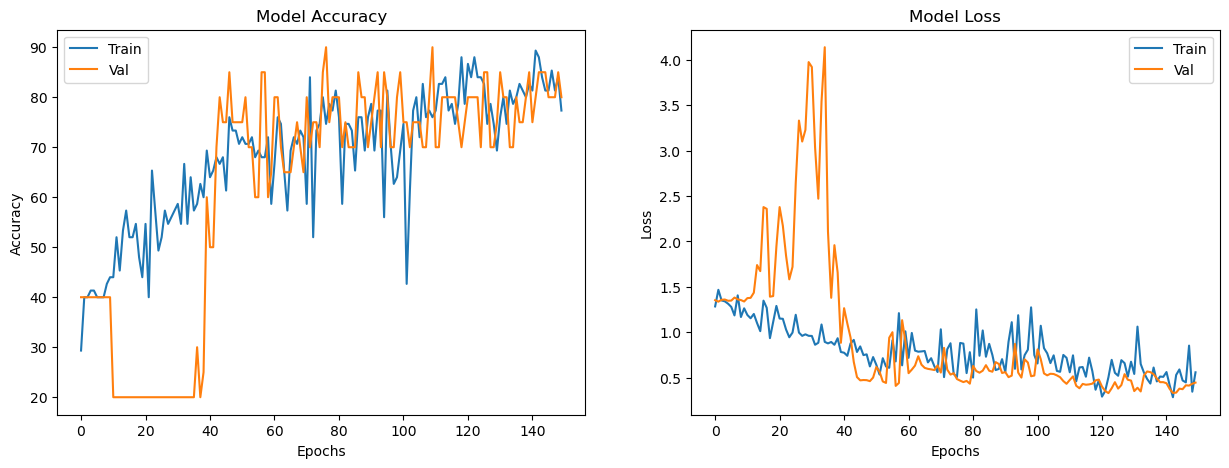

In [431]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [432]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print('predicted',predicted)
        print('labels',labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23524\1370897694.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_classification.pth'))

predicted tensor([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
labels tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
Test accuracy is 90.0%


In [433]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda().long()
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))


[[4 0 0 0]
 [1 3 0 0]
 [0 1 3 0]
 [0 0 0 8]]


In [434]:
all_labels

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]

In [435]:
all_preds

[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3]